<a href="https://colab.research.google.com/github/shresthabhi/IIT_VT_capstone_project/blob/main/code/1)_Capstone_graph_views.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import plotly.express as px
import plotly.graph_objects as go
import os
from pathlib import Path
from collections import defaultdict
import pickle

In [370]:
output_dir = Path(r"/content/drive/MyDrive/Colab Notebooks/capstone")
output_graph_dir = Path(r"/content/drive/MyDrive/Colab Notebooks/capstone/graphs_2")

In [371]:
def get_info(data):
  """
    Input:
      data(pd.DataFrame)
    Output:
      DataFrame - Null value
  """
  null_count = pd.Series(data.isna().sum(), name = "null_count")
  non_null_count = pd.Series(data.notna().sum(), name = "not_null_count")
  unique_values = pd.Series(data.nunique(), name = "unique_values")
  total = data.shape[0]

  other_info = data.describe(include = "all").T

  for col in ["unique", "count"]:
    try:
      other_info.drop(columns = [col], inplace = True)
    except: KeyError

  df = pd.concat([null_count, non_null_count, unique_values, other_info], axis = 1)
  df["perct_null_count"] = df["null_count"]/total
  df["total"] = total


  return df[["total", "null_count", "not_null_count", "perct_null_count","unique_values"] + [*other_info.columns]]

def highlight_cells(val, threshold, color_if_true, color_if_false):
    """
    Returns pandas style compatible string
    Input:
      val           : value on which highlighting is to be don
      threshold     : threshold about which color is to be highlighted
      color-if_true : color if val >= threshold
      color_if_fale : color if val < threshold  
    """

    color = color_if_true if val >= threshold else color_if_false
    return 'background-color: {}'.format(color)

def plot_histogram(data, columns = None, exclude_columns = None, verbose = False, graph_size = 5):
  """
    Input:
      data            : pd.DataFrame
      columns         : columns for which histogram has to be ploted
      exclude_columns : columns to exclude from the plot
      verbose         : Print which graph is being processed
      graph_size      : factor, size of individual graphs
    Output:
      fig, ax
  """


  if(columns == None):
    columns = [*data.columns]
  
  if(exclude_columns != None):
    columns = [col for col in columns if col not in exclude_columns]


  total_columns = len(columns)
  n_cols = min(4, total_columns)
  n_rows = math.ceil(total_columns/4)

  fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (n_cols*graph_size, n_rows*graph_size), squeeze = False)

  # if(verbose):
  #   print(total_columns, n_cols, n_rows)

  for index, col in enumerate(columns):

    ax_row_position = index//n_cols
    ax_col_position = index%n_cols

    if(verbose):
      print(index, col, ax_row_position, ax_col_position)

    sns.histplot(data = data, x = col, ax = ax[ax_row_position, ax_col_position])
    
    if(col[:5] == "perct"):
      ax[ax_row_position, ax_col_position].set_xlim(0,1)  
  plt.show()

  return fig, ax

def get_mean_variance(data, cols):
  """
    Returns mean and standard deviation of the data
  """
  return data[cols].mean(), data[cols].std()



def get_TSNE_model(data, learning_rate = 10):
  model = TSNE(learning_rate = learning_rate)
  data_tsne = model.fit_transform(data)
  x = data_tsne[:,0]
  y = data_tsne[:,1]

  return model, data_tsne


def augment_KMeans_TSNE(data, kmeans_model, tsne_learning_rate = 10):

  cluster = kmeans_model.predict(data)
  model, data_tsne = get_TSNE_model(data, tsne_learning_rate)

  x = data_tsne[:,0]
  y = data_tsne[:,1]

  fig, ax = plt.subplots(figsize = (10,10))
  
  sns.scatterplot(x=x, y=y, hue = cluster, ax =  ax)

  plt.show()

  return fig, ax, cluster, data_tsne

In [372]:
normal_color = "#130b01"
special_color = "#077187"



def get_directed_edges(G):
    
    vistited_edges = defaultdict()
    edges_1 = []
    edges_2 = []
        
    for edge in G.edges():
        if((edge[1],edge[0]) not in vistited_edges):
            edges_1.append(edge)
            vistited_edges[edge[0],edge[1]] = 1
        else:
            edges_2.append(edge)
                                  
    return edges_1, edges_2


def get_edges_widths(G, criteria, width_range = [2,12]):
    
    widths = []
    for u,v,d in G.edges(data = True):
        widths.append(d[criteria])
        
    # widths = np.array(widths)
    
    #normalize widths
    min_width = np.min(widths)
    max_width = np.max(widths)
    
    min_ = width_range[0]
    max_ = width_range[1]
    
    print(np.sum(widths))
    
    # return ((widths - min_width)/(max_width - min_width))*(max_ - min_) + min_
    return (widths/(np.sum(widths)))*(max_ - min_) + min_

def hanging_line(point1, point2, n_points):

  a = (point2[1] - point1[1])/(np.cosh(point2[0]) - np.cosh(point1[0]))
  b = point1[1] - a*np.cosh(point1[0])
  x = np.linspace(point1[0], point2[0], n_points)
  y = a*np.cosh(x) + b

  return [x,y]

def connect(posA, posB, rad):
  x1, y1 = posA
  x2, y2 = posB
  x12, y12 = (x1 + x2) / 2., (y1 + y2) / 2.
  dx, dy = x2 - x1, y2 - y1
  f = rad
  cx, cy = x12 + f * dy, y12 - f * dx

  x = [x1, cx, x2]
  y = [y1, cy, y2]

  return [x,y]


def get_graph_edges(G, pos = None, normal_color = "#130b01", special_color = "#077187"):
  
  if(pos == None):
    pos = nx.kamada_kawai_layout(G)
    print("Warning : position is not defined, using defaul kamda kawai layout")

  n_points = 3
  
  edges = np.zeros((G.number_of_edges(), 2, n_points))
  colors = np.zeros(G.number_of_edges(), dtype = 'object')
  widths = np.zeros(G.number_of_edges())
  for i, (u,v,d) in enumerate(G.edges(data = True)):

    rad = 0.05 if v.find("Not") != -1 else -0.05
    edges[i] = connect([pos[u][0], pos[u][1]], [pos[v][0], pos[v][1]], rad = rad)
    colors[i] = normal_color if v.find("Not") != -1 else special_color
    widths[i] = d["node_probability"]

  return edges, colors, widths


def get_width(width, _min, _max):
  return _min + (_max - _min)*width

def get_graph_nodes(G, pos = None, start_color = "#329A91", approved_color = "#00538F", abandoned_color = "#A3003F", normal_color = "#A3E1DC"):
  
  if(pos == None):
    pos = nx.kamada_kawai_layout(G)
    print("Warning : position is not defined, using defaul kamda kawai layout")
  
  n_nodes = G.number_of_nodes()

  x = np.zeros(n_nodes)
  y = np.zeros(n_nodes)
  labels = np.zeros(n_nodes, dtype = 'object')
  colors = np.zeros(n_nodes, dtype = 'object')


  for index, node in enumerate(G.nodes()):
    x[index] = pos[node][0]
    y[index] = pos[node][1]
    labels[index] = node

    if(node == 'Application Filed'):
      colors[index] = start_color
    elif(node in ["Appeal", "RCE", "Interview"]):
      colors[index] = normal_color
    elif(node.find("Not") == -1):
      colors[index] = approved_color
    elif(node.find("Not") != -1):
      colors[index] = abandoned_color
    else:
      colors[index] = normal_color

  return [x,y], labels, colors

def get_graph_annotations(G, edges):
  x = edges[0]
  y = edges[1]

  return None

  

def plot_graph(G, pos = None, normal_color = normal_color, special_color = special_color):
  # fig, ax = plt.subplots(1,1,figsize = (12,12))

  if(pos == None):
    pos = nx.kamada_kawai_layout(G)
    print("Warning : position is not defined, using defaul kamda kawai layout")

  edges, colors_e, widths = get_graph_edges(G, pos = pos, normal_color = normal_color, special_color = special_color)
  [nodes_x, nodes_y], labels, colors_n = get_graph_nodes(G, pos = pos)
  traces = []

  for edge, color, width in zip(edges, colors_e, widths):

    width_size = get_width(width, 0.5, 8)

    trace = go.Scatter(x = edge[0], y = edge[1], mode = 'lines', line = dict(color = color, width = width_size, shape = 'spline')\
                       , hovertemplate = "<span>&#37;</span> Application %f"%width\
                       , showlegend = False\
                       , name = '')
    traces.append(trace)

  for node_x, node_y, label, color in zip(nodes_x, nodes_y, labels, colors_n):
    traces.append(go.Scatter(x = [node_x], y = [node_y], text = label, mode = 'markers', marker = dict(size = 25, color = color),\
                         showlegend = False, hovertemplate = "%s"%label, name = ''))

  fig = go.Figure(traces, layout = go.Layout(showlegend = True, width = 800, height = 800\
                                             , xaxis=dict(showgrid=False, zeroline=False, showticklabels=False)\
                                             , yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))
  fig.update_traces(textposition='top center')


  return fig, widths


In [373]:
data_examiner = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/examiner_application_graph.csv")
data_art = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/art_unit_application_graph.csv")
data_examiner_art_info = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/examiner_art_information.csv")
data_ex_level = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/examiner_level_data.csv")
data_art_level = pd.read_csv("https://raw.githubusercontent.com/shresthabhi/IIT_VT_capstone_project/main/data/art_level_data.csv")

In [374]:
data_examiner.dropna(subset = ["examiner_name"], inplace = True)
data_examiner.drop("total_application", inplace = True, axis = 1)
data_examiner.head()

,examiner_name,node,node_next,route_application,appeal_application,interview_application,rce_application
0,"A, MINH D",Application Filed,Not Allowed,7,2.0,73.0,42.0
1,"A, MINH D",Application Filed,Allowed,92,2.0,73.0,42.0
2,"A, MINH D",Appeal,Allowed,1,2.0,73.0,42.0
3,"A, MINH D",Interview,Not Allowed,38,2.0,73.0,42.0
4,"A, MINH D",Interview,Allowed,35,2.0,73.0,42.0


In [375]:
data_art.dropna(subset = ["app_group_art_value"], inplace = True)
data_art.drop("total_application", inplace = True, axis = 1)
data_art.head()

,app_group_art_value,node,node_next,route_application,appeal_application,interview_application,rce_application
0,1600,Appeal,Not Allowed,1,1.0,5.0,4.0
1,1600,RCE,Not Allowed,4,1.0,5.0,4.0
2,1600,Application Filed,Not Allowed,14,1.0,5.0,4.0
3,1600,Interview,Not Allowed,4,1.0,5.0,4.0
4,1600,Interview,Allowed,1,1.0,5.0,4.0


In [376]:
data_examiner_art_info.head()

,examiner_name,app_group_art_value,n_application
0,"A, MINH D",2844,336
1,"A, MINH D",3734,1
2,"A, PHI DIEU TRAN",3633,220
3,"A, PHI DIEU TRAN",OPAP,1
4,"AAMIR, HAFIZ MUHAMM",1773,30


## Extracting, cleaning examiner level data

In [377]:
variables = ["perct_allowed", "perct_not_allowed", "perct_allowed_g_interview", "perct_allowed_g_appeal", "perct_allowed_g_rce", "perct_allowed_directly"]

# perct_allowed = sum(allowed)/sum(route_application)
# perct_not_allowed =  sum(not_allowed)/sum(route_application)
# perct_allowed_g_interview = sum(interview_allowed)/sum(interview_application)
# perct_allowed_g_appeal = sum(appeal_allowed)/sum(appeal_application)
# perct_allowed_g_rce = sum(rce_allowed)/sum(rce_application)
# perct_allowed_directly = directly_allowed/sum(route_application)


examiner_grouping = data_examiner.groupby(by = "examiner_name", as_index = False)
data = examiner_grouping.agg(total_application = ("route_application", "sum"))
data_examiner = data_examiner.merge(data, how = "left", on= "examiner_name")

data_examiner["node_probability"] = np.nan
data_examiner["total_probability"] = np.nan

data_examiner.loc[data_examiner.node == "Appeal", "node_probability"] = data_examiner["route_application"]*1.000/data_examiner["appeal_application"]
data_examiner.loc[data_examiner.node == "RCE", "node_probability"] = data_examiner["route_application"]*1.000/data_examiner["rce_application"]
data_examiner.loc[data_examiner.node == "Interview", "node_probability"] = data_examiner["route_application"]*1.000/data_examiner["interview_application"]
data_examiner.loc[data_examiner.node == "Application Filed", "node_probability"] = data_examiner["route_application"]*1.000/data_examiner["total_application"]
data_examiner.loc[:, "total_probability"] = data_examiner["route_application"]*1.000/data_examiner["total_application"]

### Model data

In [378]:
data_examiner_node_probability = data_examiner.pivot_table(index = "examiner_name", columns = ["node", "node_next"], aggfunc = {"node_probability" : "max"})

suffix = {"Appeal" : "appeal"
 , "Application Filed" : "directly"
 , "RCE" : "rce"
 , "Interview" : "interview"}

prefix = {"Allowed" : "allowed_g_",\
                 "Not Allowed" : "not_allowed_g_",\
                 "Appeal dismissed" : "dismissed_g_",\
                 "Partially Allowed" : "partially_allowed_g_"}

renamed_columns = {}

for col in data_examiner_node_probability.columns:
  renamed_columns[col] = "prob_{_prefix}{_suffix}".format(_prefix = prefix[col[2]], _suffix = suffix[col[1]])

data_examiner_node_probability.columns =  renamed_columns.values()

data_examiner_node_probability = data_examiner_node_probability.reset_index()
print(data_examiner_node_probability.shape)
data_examiner_node_probability.head()

(9852, 11)


,examiner_name,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_not_allowed_g_directly,prob_allowed_g_interview,prob_not_allowed_g_interview,prob_allowed_g_rce,prob_not_allowed_g_rce
0,"A, MINH D",0.500000,NaN,0.500000,NaN,0.425926,0.032407,0.479452,0.520548,NaN,1.0
1,"A, PHI DIEU TRAN",0.272727,NaN,0.727273,NaN,0.050000,0.081818,0.309735,0.690265,NaN,1.0
2,"AAMIR, HAFIZ MUHAMM",NaN,NaN,NaN,NaN,0.066667,0.066667,0.809524,0.190476,NaN,1.0
3,"ABAD, FARLEY J",NaN,NaN,NaN,NaN,0.186275,0.058824,0.584906,0.415094,NaN,1.0
4,"ABAZA, AYMAN A",1.000000,NaN,NaN,NaN,0.013158,0.046053,0.258824,0.741176,NaN,1.0


In [379]:
data_examiner_tot_probability = data_examiner.pivot_table(index = "examiner_name", columns =  ["node_next"], aggfunc = {"total_probability" : "sum"})
data_examiner_tot_probability.columns = ["prob_allowed", "prob_dismissed", "prob_not_allowed", "prob_partially_allowed"]

data_examiner_tot_probability = data_examiner_tot_probability.reset_index()
print(data_examiner_tot_probability.shape)
data_examiner_tot_probability.head()

(9852, 5)


,examiner_name,prob_allowed,prob_dismissed,prob_not_allowed,prob_partially_allowed
0,"A, MINH D",0.592593,NaN,0.407407,NaN
1,"A, PHI DIEU TRAN",0.222727,NaN,0.777273,NaN
2,"AAMIR, HAFIZ MUHAMM",0.633333,NaN,0.366667,NaN
3,"ABAD, FARLEY J",0.490196,NaN,0.509804,NaN
4,"ABAZA, AYMAN A",0.171053,NaN,0.828947,NaN


In [380]:
data_examiner_tot_probability_2 = data_examiner.pivot_table(index = "examiner_name", columns =  ["node"], aggfunc = {"total_probability" : "sum"})
data_examiner_tot_probability_2.columns = ["prob_appeal", "prob_app_filed", "prob_interview", "prob_rce"]
data_examiner_tot_probability_2 = data_examiner_tot_probability_2.drop("prob_app_filed", axis = 1)

data_examiner_tot_probability_2 = data_examiner_tot_probability_2.reset_index()
print(data_examiner_tot_probability_2.shape)
data_examiner_tot_probability_2.head()

(9852, 4)


,examiner_name,prob_appeal,prob_interview,prob_rce
0,"A, MINH D",0.009259,0.337963,0.194444
1,"A, PHI DIEU TRAN",0.050000,0.513636,0.304545
2,"AAMIR, HAFIZ MUHAMM",NaN,0.700000,0.166667
3,"ABAD, FARLEY J",NaN,0.519608,0.235294
4,"ABAZA, AYMAN A",0.013158,0.559211,0.368421


In [381]:
data_examiner_model = data_examiner_node_probability.merge(data_examiner_tot_probability, on = "examiner_name", how = "inner")
data_examiner_model = data_examiner_model.merge(data_examiner_tot_probability_2, on = "examiner_name", how = "inner")
data_examiner_model.shape

(9852, 18)

In [382]:
data_examiner_art_info_primary = data_examiner_art_info.loc[data_examiner_art_info.groupby('examiner_name')["n_application"].idxmax()]
data_examiner_art_info_primary = data_examiner_art_info_primary.drop("n_application", axis = 1)
data_examiner_art_info_primary.head()

,examiner_name,app_group_art_value
0,"A, MINH D",2844
2,"A, PHI DIEU TRAN",3633
4,"AAMIR, HAFIZ MUHAMM",1773
7,"ABAD, FARLEY J",2181
10,"ABAZA, AYMAN A",2419


In [383]:
data_examiner_model = data_examiner_model.merge(data_examiner_art_info_primary, on = "examiner_name", how = "inner")
print(data_examiner_model.shape)

(9852, 19)


In [384]:
data_ex_level["average_days_to_first_action"].fillna(data_ex_level["average_days_to_first_action"].mean(), inplace = True)
data_ex_level["average_days_to_first_action"] - data_ex_level["average_days_to_first_action"].mean()


0       -139.696403
1        166.800052
2        -14.003326
3        -17.204453
4         42.764100
            ...    
10352    131.762165
10353    -68.468604
10354    -56.468604
10355    425.331396
10356    -26.801938
Name: average_days_to_first_action, Length: 10357, dtype: float64

In [385]:
data_examiner_model = data_examiner_model.fillna(0)
data_examiner_model.head()

,examiner_name,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_not_allowed_g_directly,prob_allowed_g_interview,prob_not_allowed_g_interview,prob_allowed_g_rce,prob_not_allowed_g_rce,prob_allowed,prob_dismissed,prob_not_allowed,prob_partially_allowed,prob_appeal,prob_interview,prob_rce,app_group_art_value
0,"A, MINH D",0.500000,0.0,0.500000,0.0,0.425926,0.032407,0.479452,0.520548,0.0,1.0,0.592593,0.0,0.407407,0.0,0.009259,0.337963,0.194444,2844
1,"A, PHI DIEU TRAN",0.272727,0.0,0.727273,0.0,0.050000,0.081818,0.309735,0.690265,0.0,1.0,0.222727,0.0,0.777273,0.0,0.050000,0.513636,0.304545,3633
2,"AAMIR, HAFIZ MUHAMM",0.000000,0.0,0.000000,0.0,0.066667,0.066667,0.809524,0.190476,0.0,1.0,0.633333,0.0,0.366667,0.0,0.000000,0.700000,0.166667,1773
3,"ABAD, FARLEY J",0.000000,0.0,0.000000,0.0,0.186275,0.058824,0.584906,0.415094,0.0,1.0,0.490196,0.0,0.509804,0.0,0.000000,0.519608,0.235294,2181
4,"ABAZA, AYMAN A",1.000000,0.0,0.000000,0.0,0.013158,0.046053,0.258824,0.741176,0.0,1.0,0.171053,0.0,0.828947,0.0,0.013158,0.559211,0.368421,2419


### Graph data

In [196]:
graphs = {}

examiners = data_examiner.examiner_name.unique()
data_examiner_1 = data_examiner.copy()

data_examiner_1["target"] = ""
data_examiner_1.loc[data_examiner_1.node == "Appeal", "target"] = "Appeal " + data_examiner_1.node_next
data_examiner_1.loc[data_examiner_1.node == "RCE", "target"] = "RCE " + data_examiner_1.node_next
data_examiner_1.loc[data_examiner_1.node == "Interview", "target"] = "Int. " + data_examiner_1.node_next
data_examiner_1.loc[data_examiner_1.node == "Application Filed", "target"] = data_examiner_1.node_next


for index, examiner in enumerate(examiners):
  df = data_examiner_1[data_examiner_1.examiner_name == examiner]

  graph = nx.from_pandas_edgelist(df = df, source = "node", target = "target",
                                  edge_attr = ["node_probability"],\
                                   create_using= nx.MultiDiGraph)
  
  extra_edges_data = data_examiner_model[data_examiner_model.examiner_name == examiner]
  prob_appeal = extra_edges_data.loc[ : , "prob_appeal"].values[0]
  prob_rce = extra_edges_data.loc[ : , "prob_rce"].values[0]
  prob_interview = extra_edges_data.loc[ : , "prob_interview"].values[0]


  graph.add_edge("Application Filed", "Appeal", node_probability = prob_appeal)
  graph.add_edge("Application Filed", "RCE", node_probability = prob_rce)
  graph.add_edge("Application Filed", "Interview", node_probability = prob_interview)

  graphs[examiner] = graph
  
  examiner_dir = os.path.join(output_graph_dir, examiner)
  os.makedirs(examiner_dir,  exist_ok = True)

  path_to_save = os.path.join(examiner_dir, "graph.pickle")

  file = open(path_to_save, "wb")
  pickle.dump(graph, file)
  file.close()

  break

4.0


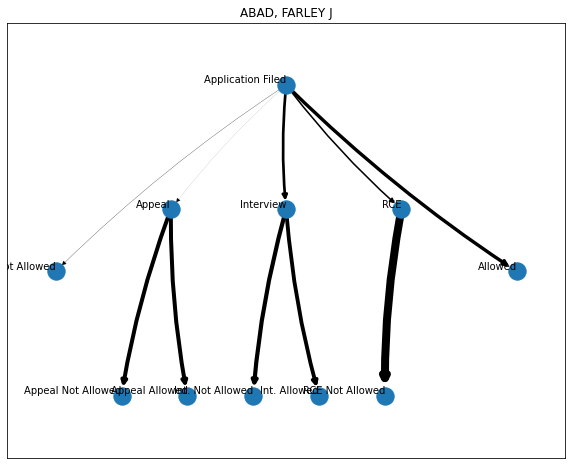

In [213]:
graph = [*graphs.values()][0]
# pos = nx.kamada_kawai_layout(graph)

fig, ax = plt.subplots(1,1,figsize = (10,8))

pos = {'Application Filed': np.array([0 , 1]),
 'Not Allowed': np.array([-1, 0.25]),
 'Allowed': np.array([1, 0.25]),
 'Appeal': np.array([-0.5,  0.5]),
 'Appeal Not Allowed': np.array([-1+2/7,  -0.25]),
 'Appeal Allowed': np.array([-1+4/7,  -0.25]),
 'Interview': np.array([0, 0.5]),
 'Int. Not Allowed': np.array([-1+6/7,  -0.25]),
 'Int. Allowed': np.array([-1+8/7, -0.25]),
 'RCE': np.array([0.5, 0.5]),
 'RCE Not Allowed': np.array([-1+10/7,  -0.25]),
 'RCE Allowed': np.array([-1+12/7,  -0.25])}

widths_DG = get_edges_widths(graph, "node_probability", width_range = [2,12])
edges1, edges2 = get_directed_edges(graph)

width = np.array([])
for u,v,d in graph.edges(data=True):
  width = np.append(width, d["node_probability"])

nx.draw_networkx_nodes(graph, pos = pos, ax = ax)
nx.draw_networkx_labels(graph, pos = pos, ax = ax, font_size = 10, verticalalignment = 'bottom',
                        horizontalalignment = 'right')
nx.draw_networkx_edges(graph, pos = pos, width = width*8, edgelist =  edges1, ax = ax, 
                        edge_color = "black", connectionstyle = 'arc3,rad=0.05')
nx.draw_networkx_edges(graph, pos = pos, width = width*8, edgelist =  edges2, ax = ax, 
                        edge_color = "black", connectionstyle = 'arc3,rad=0.05')

ax.set_title(examiners[3])
ax.set_ylim([-0.5, 1.25])
fig.savefig("examiner_2")

## Extracting, cleaning art unit level data

In [120]:
variables = ["perct_allowed", "perct_not_allowed", "perct_allowed_g_interview", "perct_allowed_g_appeal", "perct_allowed_g_rce", "perct_allowed_directly"]

# perct_allowed = sum(allowed)/sum(route_application)
# perct_not_allowed =  sum(not_allowed)/sum(route_application)
# perct_allowed_g_interview = sum(interview_allowed)/sum(interview_application)
# perct_allowed_g_appeal = sum(appeal_allowed)/sum(appeal_application)
# perct_allowed_g_rce = sum(rce_allowed)/sum(rce_application)
# perct_allowed_directly = directly_allowed/sum(route_application)


art_grouping = data_art.groupby(by = "app_group_art_value", as_index = False)
data = art_grouping.agg(total_application = ("route_application", "sum"))
data_art = data_art.merge(data, how = "left", on= "app_group_art_value")

data_art["node_probability"] = np.nan
data_art["total_probability"] = np.nan

data_art.loc[data_art.node == "Appeal", "node_probability"] = data_art["route_application"]*1.000/data_art["appeal_application"]
data_art.loc[data_art.node == "RCE", "node_probability"] = data_art["route_application"]*1.000/data_art["rce_application"]
data_art.loc[data_art.node == "Interview", "node_probability"] = data_art["route_application"]*1.000/data_art["interview_application"]
data_art.loc[data_art.node == "Application Filed", "node_probability"] = data_art["route_application"]*1.000/data_art["total_application"]
data_art.loc[:, "total_probability"] = data_art["route_application"]*1.000/data_art["total_application"]

### Model Data

In [121]:
data_art_node_probability = data_art.pivot_table(index = "app_group_art_value", columns = ["node", "node_next"], aggfunc = {"node_probability" : "max"})

suffix = {"Appeal" : "appeal"
 , "Application Filed" : "directly"
 , "RCE" : "rce"
 , "Interview" : "interview"}

prefix = {"Allowed" : "allowed_g_",\
                 "Not Allowed" : "not_allowed_g_",\
                 "Appeal dismissed" : "dismissed_g_",\
                 "Partially Allowed" : "partially_allowed_g_"}

renamed_columns = {}

for col in data_art_node_probability.columns:
  renamed_columns[col] = "prob_{_prefix}{_suffix}".format(_prefix = prefix[col[2]], _suffix = suffix[col[1]])

data_art_node_probability.columns =  renamed_columns.values()

data_art_node_probability = data_art_node_probability.reset_index()
print(data_art_node_probability.shape)
data_art_node_probability.head()

(634, 11)


,app_group_art_value,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_not_allowed_g_directly,prob_allowed_g_interview,prob_not_allowed_g_interview,prob_allowed_g_rce,prob_not_allowed_g_rce
0,1600,NaN,NaN,1.000000,NaN,0.040000,0.560000,0.200000,0.800000,NaN,1.000000
1,1611,0.104167,NaN,0.895833,NaN,0.016386,0.098313,0.586692,0.413308,0.002770,0.997230
2,1612,0.280000,NaN,0.696000,0.024000,0.047120,0.117053,0.357061,0.642939,0.002421,0.997579
3,1613,0.133333,NaN,0.866667,NaN,0.018416,0.106814,0.597603,0.402397,0.001791,0.998209
4,1615,0.193182,NaN,0.784091,0.022727,0.024775,0.127628,0.584513,0.415487,0.003096,0.996904


In [122]:
data_art_tot_probability = data_art.pivot_table(index = "app_group_art_value", columns =  ["node_next"], aggfunc = {"total_probability" : "sum"})
data_art_tot_probability.columns = ["prob_allowed", "prob_dismissed", "prob_not_allowed", "prob_partially_allowed"]

data_art_tot_probability = data_art_tot_probability.reset_index()
print(data_art_tot_probability.shape)
data_art_tot_probability.head()

(634, 5)


,app_group_art_value,prob_allowed,prob_dismissed,prob_not_allowed,prob_partially_allowed
0,1600,0.080000,NaN,0.920000,NaN
1,1611,0.321446,NaN,0.678554,NaN
2,1612,0.177636,NaN,0.821242,0.001122
3,1613,0.280663,NaN,0.719337,NaN
4,1615,0.295796,NaN,0.703453,0.000751


In [162]:
data_art_tot_probability_2 = data_art.pivot_table(index = "app_group_art_value", columns =  ["node"], aggfunc = {"total_probability" : "sum"})
data_art_tot_probability_2.columns = ["prob_appeal", "prob_app_filed", "prob_interview", "prob_rce"]
data_art_tot_probability_2 = data_art_tot_probability_2.drop("prob_app_filed", axis = 1)

data_art_tot_probability_2 = data_art_tot_probability_2.reset_index()
print(data_art_tot_probability_2.shape)
data_art_tot_probability_2.head()

(634, 4)


,app_group_art_value,prob_appeal,prob_interview,prob_rce
0,1600,0.040000,0.200000,0.160000
1,1611,0.023133,0.514217,0.347952
2,1612,0.046746,0.325729,0.463351
3,1613,0.033149,0.430203,0.411418
4,1615,0.033033,0.450826,0.363739


In [163]:
data_art_model = data_art_node_probability.merge(data_art_tot_probability, on = "app_group_art_value", how = "inner")
data_art_model = data_art_model.merge(data_art_tot_probability_2, on = "app_group_art_value", how = "inner")
print(data_art_model.shape)

(634, 18)


In [166]:
data_art_model = data_art_model.fillna(0)
data_art_model.head()

,app_group_art_value,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_not_allowed_g_directly,prob_allowed_g_interview,prob_not_allowed_g_interview,prob_allowed_g_rce,prob_not_allowed_g_rce,prob_allowed,prob_dismissed,prob_not_allowed,prob_partially_allowed,prob_appeal,prob_interview,prob_rce
0,1600,0.000000,0.0,1.000000,0.000000,0.040000,0.560000,0.200000,0.800000,0.000000,1.000000,0.080000,0.0,0.920000,0.000000,0.040000,0.200000,0.160000
1,1611,0.104167,0.0,0.895833,0.000000,0.016386,0.098313,0.586692,0.413308,0.002770,0.997230,0.321446,0.0,0.678554,0.000000,0.023133,0.514217,0.347952
2,1612,0.280000,0.0,0.696000,0.024000,0.047120,0.117053,0.357061,0.642939,0.002421,0.997579,0.177636,0.0,0.821242,0.001122,0.046746,0.325729,0.463351
3,1613,0.133333,0.0,0.866667,0.000000,0.018416,0.106814,0.597603,0.402397,0.001791,0.998209,0.280663,0.0,0.719337,0.000000,0.033149,0.430203,0.411418
4,1615,0.193182,0.0,0.784091,0.022727,0.024775,0.127628,0.584513,0.415487,0.003096,0.996904,0.295796,0.0,0.703453,0.000751,0.033033,0.450826,0.363739


In [218]:
graphs_art = {}

arts = data_art.app_group_art_value.unique()
data_art_1 = data_art.copy()

data_art_1["target"] = ""
data_art_1.loc[data_art_1.node == "Appeal", "target"] = "Appeal " + data_art_1.node_next
data_art_1.loc[data_art_1.node == "RCE", "target"] = "RCE " + data_art_1.node_next
data_art_1.loc[data_art_1.node == "Interview", "target"] = "Int. " + data_art_1.node_next
data_art_1.loc[data_art_1.node == "Application Filed", "target"] = data_art_1.node_next


for index, art in enumerate(arts):
  df = data_art_1[data_art_1.app_group_art_value == art]

  graph = nx.from_pandas_edgelist(df = df, source = "node", target = "target",
                                  edge_attr = ["node_probability"],\
                                   create_using= nx.MultiDiGraph)
  
  extra_edges_data = data_art_model[data_art_model.app_group_art_value == art]
  prob_appeal = extra_edges_data.loc[ : , "prob_appeal"].values[0]
  prob_rce = extra_edges_data.loc[ : , "prob_rce"].values[0]
  prob_interview = extra_edges_data.loc[ : , "prob_interview"].values[0]


  graph.add_edge("Application Filed", "Appeal", node_probability = prob_appeal)
  graph.add_edge("Application Filed", "RCE", node_probability = prob_rce)
  graph.add_edge("Application Filed", "Interview", node_probability = prob_interview)

  graphs_art[art] = graph
  
  art_dir = os.path.join(output_graph_dir, art)
  os.makedirs(art_dir,  exist_ok = True)

  path_to_save = os.path.join(art_dir, "graph.pickle")

  file = open(path_to_save, "wb")
  pickle.dump(graph, file)
  file.close()

<ipython-input-224-82479ba20b27>:3: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


4.0


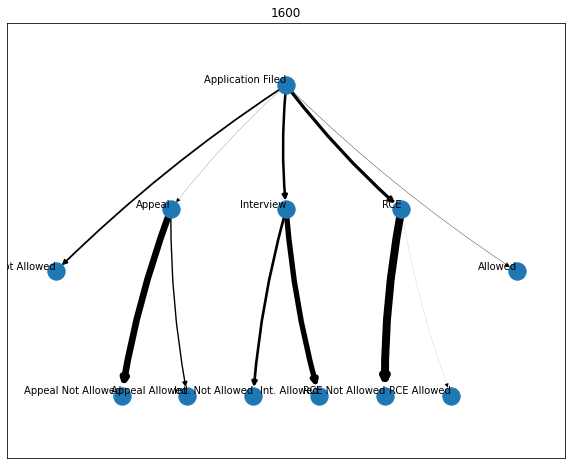

In [224]:
graph = [*graphs_art.values()][32]
# pos = nx.kamada_kawai_layout(graph)
pos = graphviz_layout(graph, prog="dot")
fig, ax = plt.subplots(1,1,figsize = (10,8))

pos = {'Application Filed': np.array([0 , 1]),
 'Not Allowed': np.array([-1, 0.25]),
 'Allowed': np.array([1, 0.25]),
 'Appeal': np.array([-0.5,  0.5]),
 'Appeal Not Allowed': np.array([-1+2/7,  -0.25]),
 'Appeal Allowed': np.array([-1+4/7,  -0.25]),
 'Interview': np.array([0, 0.5]),
 'Int. Not Allowed': np.array([-1+6/7,  -0.25]),
 'Int. Allowed': np.array([-1+8/7, -0.25]),
 'RCE': np.array([0.5, 0.5]),
 'RCE Not Allowed': np.array([-1+10/7,  -0.25]),
 'RCE Allowed': np.array([-1+12/7,  -0.25])}

widths_DG = get_edges_widths(graph, "node_probability", width_range = [2,12])
edges1, edges2 = get_directed_edges(graph)

width = np.array([])
for u,v,d in graph.edges(data=True):
  width = np.append(width, d["node_probability"])

nx.draw_networkx_nodes(graph, pos = pos, ax = ax)
nx.draw_networkx_labels(graph, pos = pos, ax = ax, font_size = 10, verticalalignment = 'bottom',
                        horizontalalignment = 'right')
nx.draw_networkx_edges(graph, pos = pos, width = width*8, edgelist =  edges1, ax = ax, 
                        edge_color = "black", connectionstyle = 'arc3,rad=0.05')
nx.draw_networkx_edges(graph, pos = pos, width = width*8, edgelist =  edges2, ax = ax, 
                        edge_color = "black", connectionstyle = 'arc3,rad=0.05')

ax.set_title(arts[0])
ax.set_ylim([-0.5, 1.25])
fig.savefig("examiner_2")

<ipython-input-228-d039295bb992>:1: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


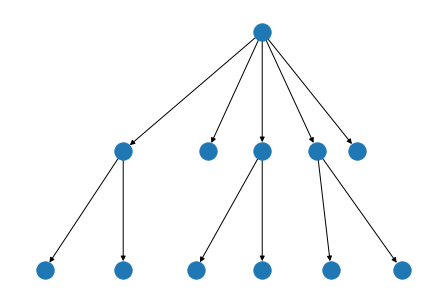

In [228]:
pos = graphviz_layout(graph, prog="dot")
nx.draw(graph, pos)
plt.show()

In [237]:
pos = {'Application Filed': np.array([0 , 1]),
 'Not Allowed': np.array([-1, 0.25]),
 'Allowed': np.array([1, 0.25]),
 'Appeal': np.array([-0.5,  0.5]),
 'Appeal Not Allowed': np.array([-1+2/7,  -0.25]),
 'Appeal Allowed': np.array([-1+4/7,  -0.25]),
 'Interview': np.array([0, 0.5]),
 'Int. Not Allowed': np.array([-1+6/7,  -0.25]),
 'Int. Allowed': np.array([-1+8/7, -0.25]),
 'RCE': np.array([0.5, 0.5]),
 'RCE Not Allowed': np.array([-1+10/7,  -0.25]),
 'RCE Allowed': np.array([-1+12/7,  -0.25])}
fig, _ = plot_graph(graph, pos) 
fig.show()

In [ ]:
# {'Application Filed': (554.84, 162.0),
#   'Appeal': (253.84, 90.0),
#  'Appeal Not Allowed': (83.843, 18.0),
#  ,
#  'Not Allowed': (436.84, 90.0),
#  'Interview': (554.84, 90.0),
#  'Int. Not Allowed': (410.84, 18.0),
#  'RCE': (673.84, 90.0),
#  'RCE Not Allowed': (703.84, 18.0),
#  'Appeal Allowed': (253.84, 18.0),
#  'RCE Allowed': (856.84, 18.0),
#  'Allowed': (760.84, 90.0),
#  'Int. Allowed': (554.84, 18.0)}

In [239]:
data_info = get_info(data_examiner_model)

data_info.style.format()\
            .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
            .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3")

# display(HTML(data_info.style.format()\
#             .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
#             .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3").render()))

,total,null_count,not_null_count,perct_null_count,unique_values,top,freq,mean,std,min,25%,50%,75%,max
examiner_name,9852,0,9852,0.000000,9852,"A, MINH D",1,nan,nan,nan,nan,nan,nan,nan
prob_allowed_g_appeal,9852,0,9852,0.000000,63,nan,nan,0.179948,0.322510,0.000000,0.000000,0.000000,0.250000,1.000000
prob_dismissed_g_appeal,9852,0,9852,0.000000,13,nan,nan,0.000587,0.019688,0.000000,0.000000,0.000000,0.000000,1.000000
prob_not_allowed_g_appeal,9852,0,9852,0.000000,65,nan,nan,0.369175,0.433062,0.000000,0.000000,0.000000,1.000000,1.000000
prob_partially_allowed_g_appeal,9852,0,9852,0.000000,22,nan,nan,0.012308,0.082622,0.000000,0.000000,0.000000,0.000000,1.000000
prob_allowed_g_directly,9852,0,9852,0.000000,3666,nan,nan,0.159826,0.232821,0.000000,0.003128,0.054707,0.211765,1.000000
prob_not_allowed_g_directly,9852,0,9852,0.000000,2717,nan,nan,0.116137,0.178885,0.000000,0.031250,0.065829,0.118644,1.000000
prob_allowed_g_interview,9852,0,9852,0.000000,2698,nan,nan,0.501926,0.275292,0.000000,0.312500,0.516129,0.700000,1.000000
prob_not_allowed_g_interview,9852,0,9852,0.000000,2698,nan,nan,0.451180,0.270935,0.000000,0.250000,0.448276,0.645833,1.000000
prob_allowed_g_rce,9852,0,9852,0.000000,140,nan,nan,0.002901,0.017317,0.000000,0.000000,0.000000,0.000000,1.000000


0 prob_allowed_g_appeal 0 0
1 prob_dismissed_g_appeal 0 1
2 prob_not_allowed_g_appeal 0 2
3 prob_partially_allowed_g_appeal 0 3
4 prob_allowed_g_directly 1 0
5 prob_not_allowed_g_directly 1 1
6 prob_allowed_g_interview 1 2
7 prob_not_allowed_g_interview 1 3
8 prob_allowed_g_rce 2 0
9 prob_not_allowed_g_rce 2 1
10 prob_allowed 2 2
11 prob_dismissed 2 3
12 prob_not_allowed 3 0
13 prob_partially_allowed 3 1
14 prob_appeal 3 2
15 prob_interview 3 3
16 prob_rce 4 0
17 app_group_art_value 4 1


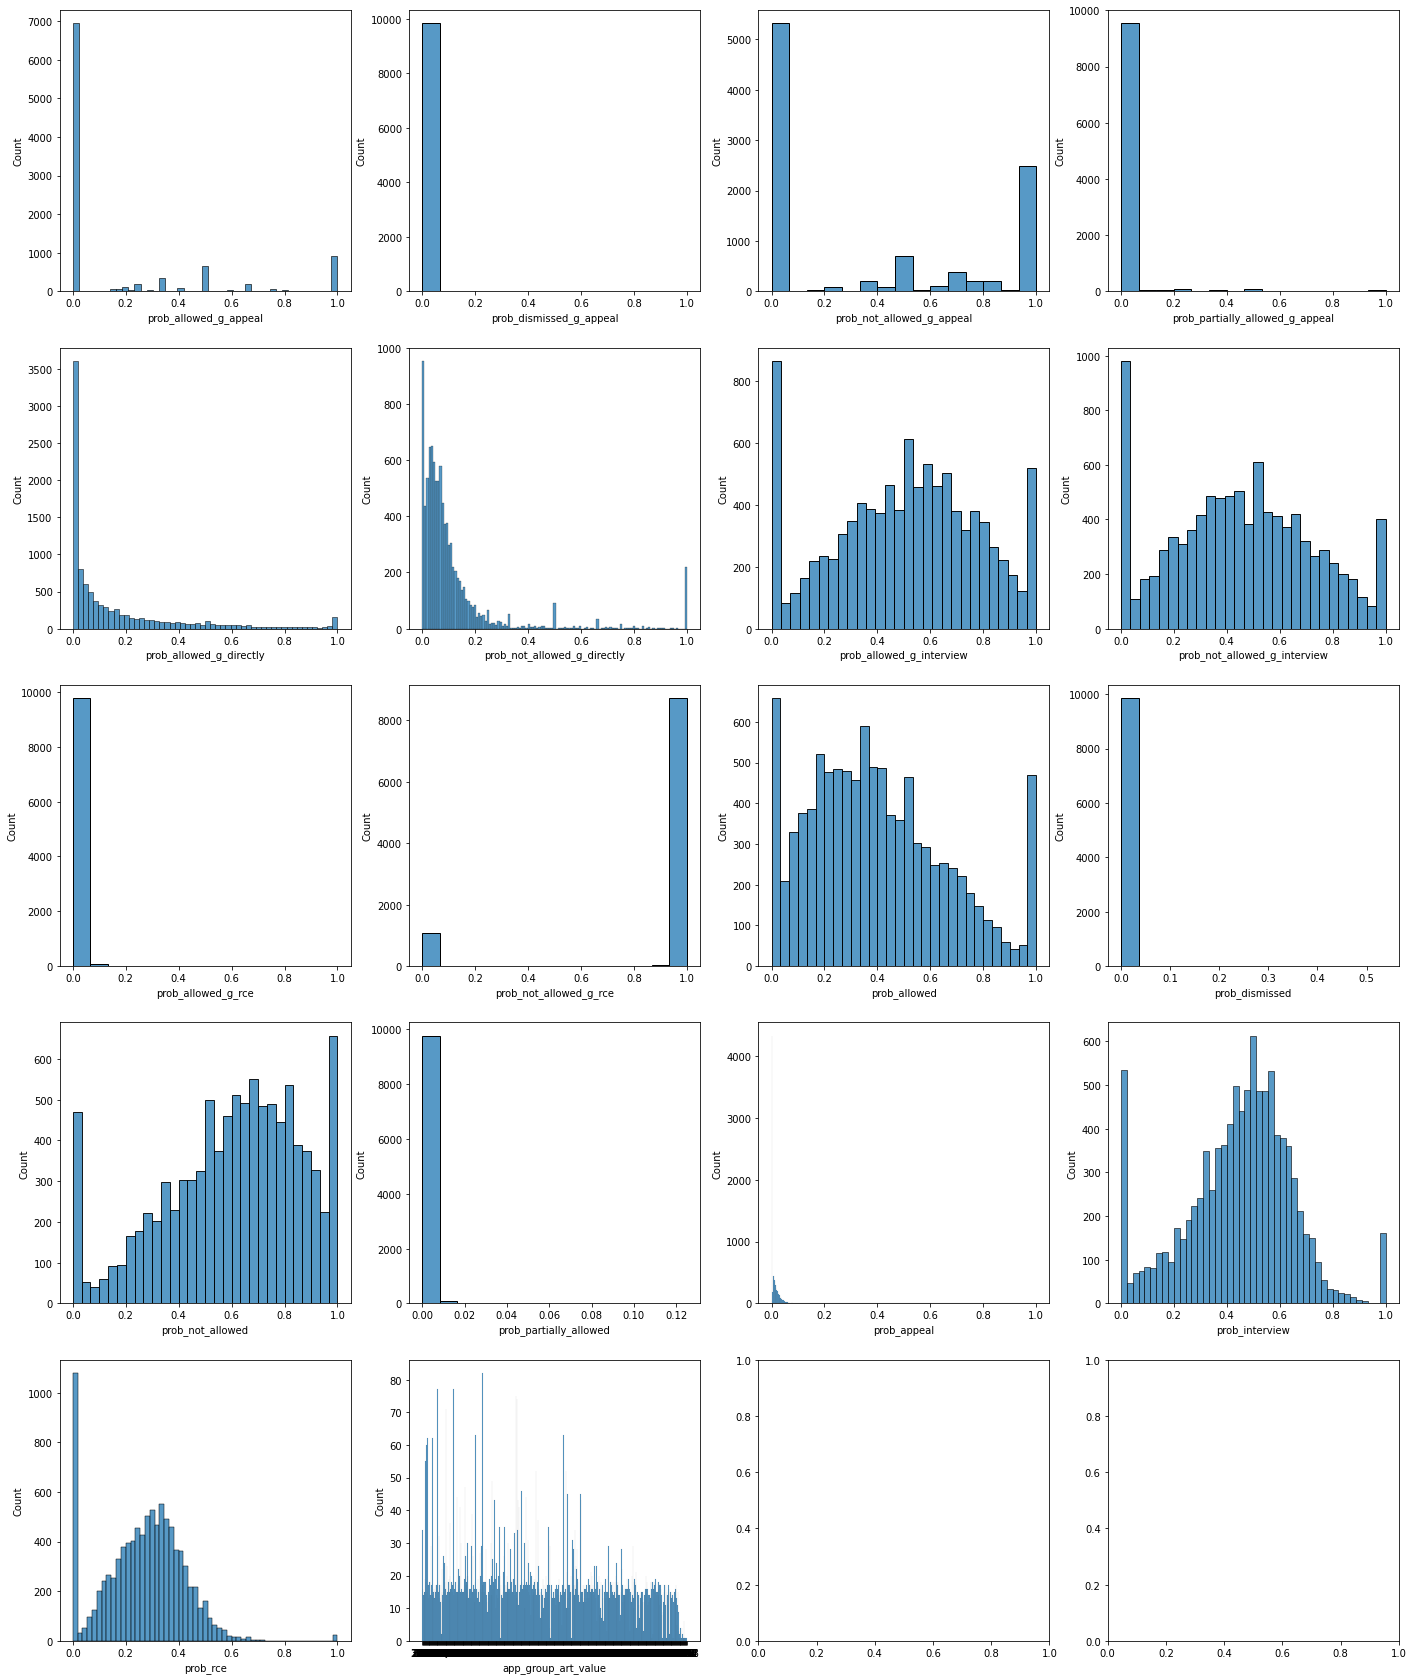

In [240]:
fig, ax = plot_histogram(data_examiner_model, exclude_columns = ["examiner_name"], verbose = True, graph_size = 6)

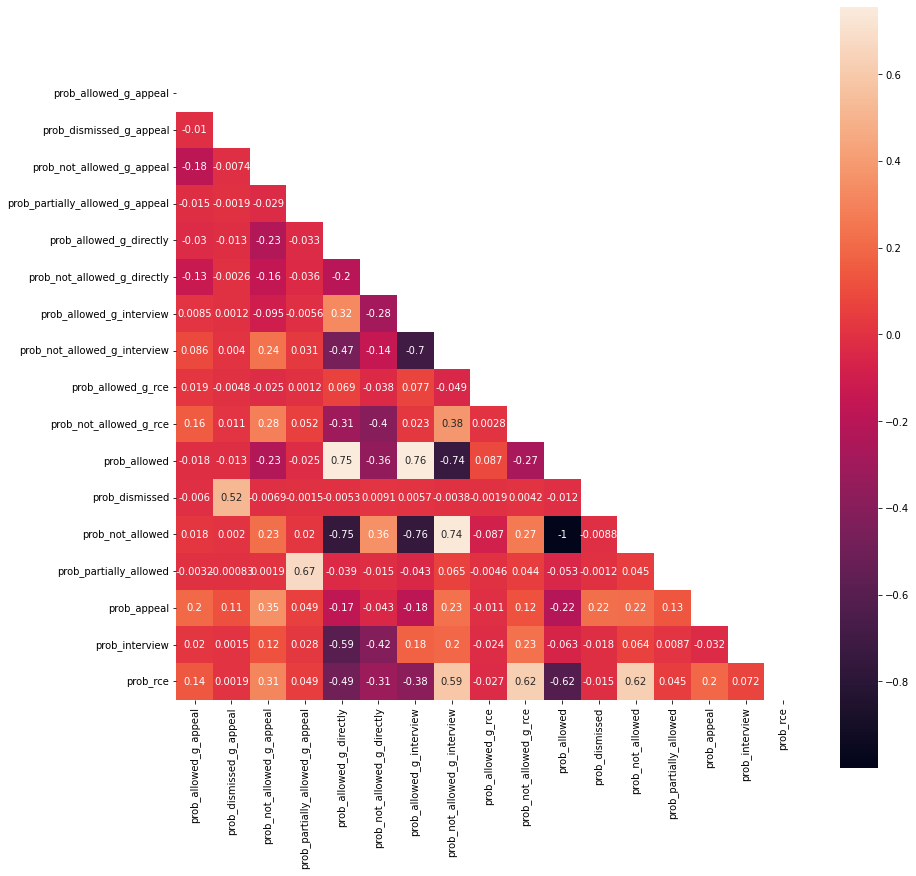

In [245]:
fig, ax = plt.subplots(figsize = (14,14))

corr = data_examiner_model.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot = True, ax = ax, square = True, mask = mask)

# name = dir + "without_outlier.png"
# plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [332]:
train_columns = ["prob_allowed_g_appeal", "prob_dismissed_g_appeal", "prob_not_allowed_g_appeal", "prob_partially_allowed_g_appeal", "prob_allowed_g_directly"\
                 , "prob_allowed_g_interview", "prob_allowed_g_rce"\
                 , "prob_allowed", "prob_dismissed", "prob_rce", "prob_appeal", "prob_interview"]

train_data = data_examiner_model[train_columns].copy()

train_data_info = get_info(train_data)

train_data_info.style.format()\
            .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
            .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3")

,total,null_count,not_null_count,perct_null_count,unique_values,mean,std,min,25%,50%,75%,max
prob_allowed_g_appeal,9852,0,9852,0.000000,63,0.179948,0.322510,0.000000,0.000000,0.000000,0.250000,1.000000
prob_dismissed_g_appeal,9852,0,9852,0.000000,13,0.000587,0.019688,0.000000,0.000000,0.000000,0.000000,1.000000
prob_not_allowed_g_appeal,9852,0,9852,0.000000,65,0.369175,0.433062,0.000000,0.000000,0.000000,1.000000,1.000000
prob_partially_allowed_g_appeal,9852,0,9852,0.000000,22,0.012308,0.082622,0.000000,0.000000,0.000000,0.000000,1.000000
prob_allowed_g_directly,9852,0,9852,0.000000,3666,0.159826,0.232821,0.000000,0.003128,0.054707,0.211765,1.000000
prob_allowed_g_interview,9852,0,9852,0.000000,2698,0.501926,0.275292,0.000000,0.312500,0.516129,0.700000,1.000000
prob_allowed_g_rce,9852,0,9852,0.000000,140,0.002901,0.017317,0.000000,0.000000,0.000000,0.000000,1.000000
prob_allowed,9852,0,9852,0.000000,5444,0.397532,0.259667,0.000000,0.197896,0.363636,0.562113,1.000000
prob_dismissed,9852,0,9852,0.000000,17,0.000064,0.005430,0.000000,0.000000,0.000000,0.000000,0.538462
prob_rce,9852,0,9852,0.000000,4037,0.266548,0.150266,0.000000,0.168990,0.279720,0.367089,1.000000


In [333]:
n_cluster = 10
intertias = []
models = []


for n in range(1,n_cluster+1):

  model = KMeans(n_clusters = n, n_init = 10, random_state = 1234)
  model.fit(train_data)
  models.append(model)
  intertias.append(model.inertia_)

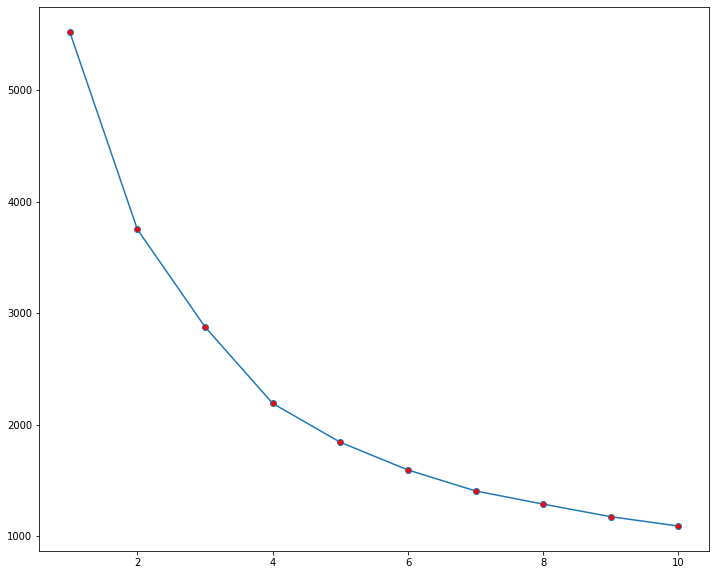

In [334]:
fig, ax = plt.subplots(figsize = (12,10))

plt.plot([*range(1,n_cluster+1)], intertias, marker = 'o', markerfacecolor = "red")

In [335]:
model_5_ex = KMeans(n_clusters = 5, n_init = 10, random_state = 1234)
model_5_ex.fit(train_data)

centres_ex = model_5_ex.cluster_centers_

results_5_ex = pd.DataFrame(centres_ex, columns = train_data.columns)


results_5_ex

,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_allowed_g_interview,prob_allowed_g_rce,prob_allowed,prob_dismissed,prob_rce,prob_appeal,prob_interview
0,0.070536,6.031950e-04,0.917386,0.011474,0.088913,0.463842,0.002302,0.318149,1.668877e-05,0.325482,0.023932,0.476871
1,0.003081,1.896371e-03,0.003784,0.014345,0.038886,0.190295,0.001440,0.129420,3.549676e-04,0.289586,0.000890,0.379435
2,0.002095,-1.355253e-17,0.004604,0.016580,0.124756,0.716748,0.003372,0.539435,-5.692061e-19,0.195991,0.000284,0.569731
3,0.049090,-2.059984e-18,0.034747,0.004783,0.717836,0.704990,0.005548,0.851453,6.911789e-19,0.076671,0.000911,0.158909
4,0.763799,3.918857e-04,0.224070,0.011739,0.131842,0.501735,0.003315,0.379768,8.189621e-06,0.311314,0.021358,0.461704


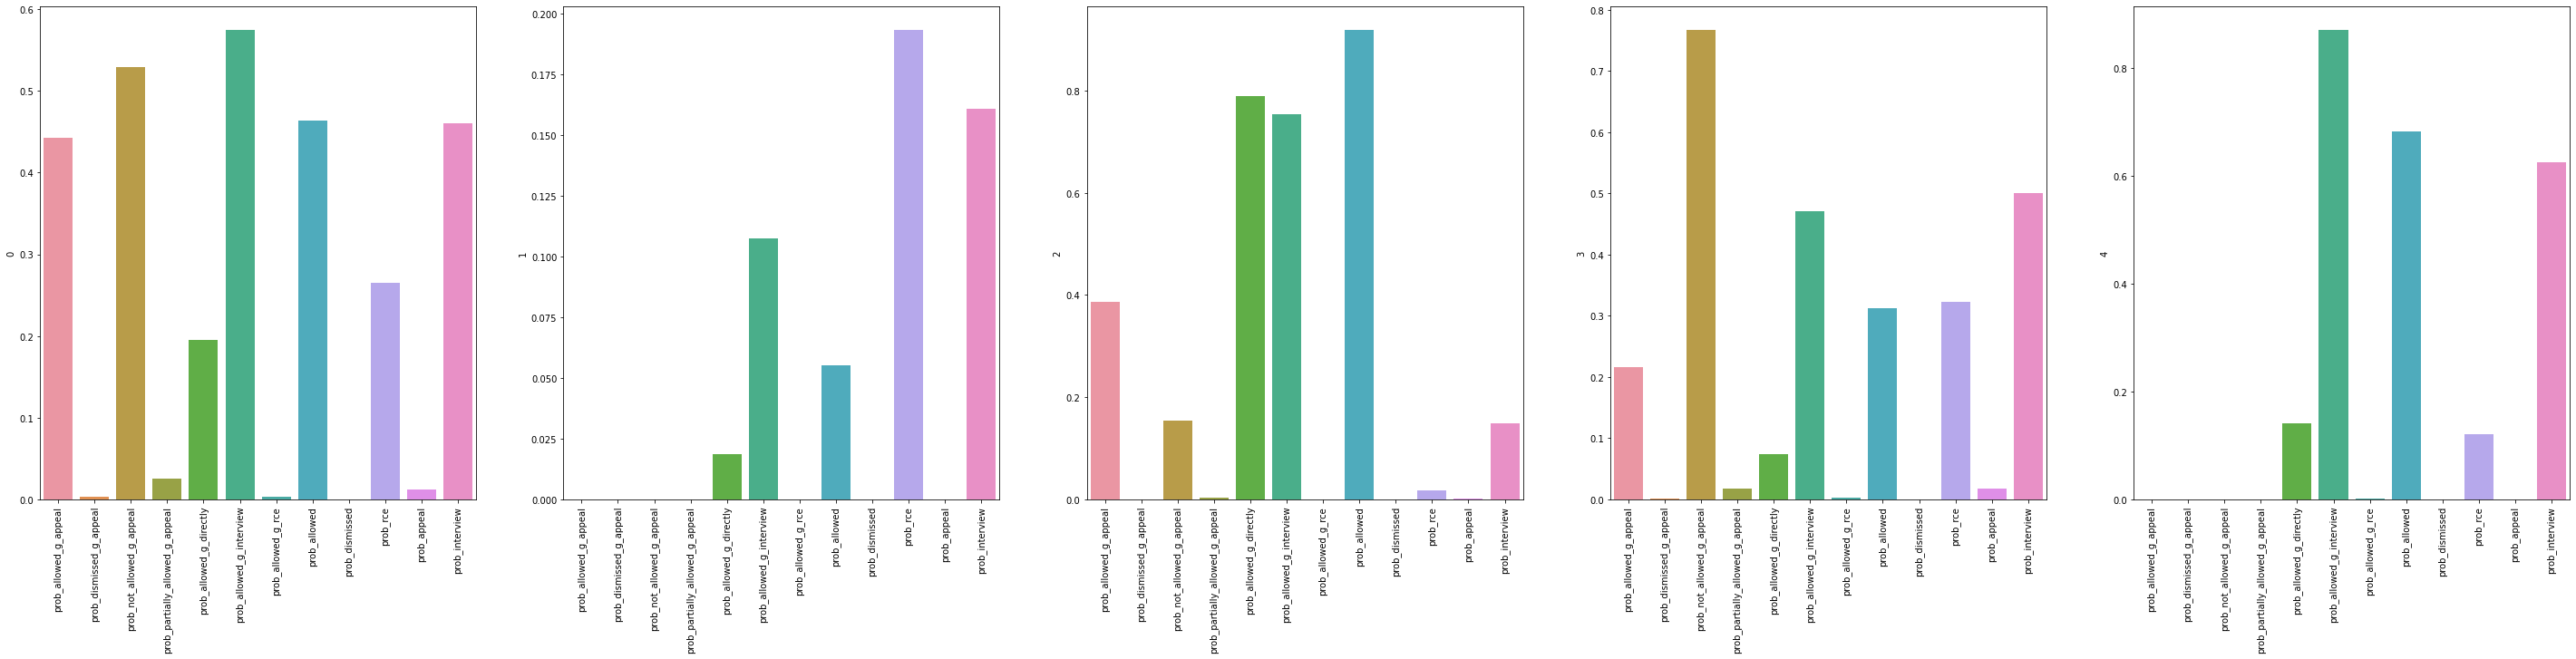

In [336]:
fig, ax = plt.subplots(figsize = (50,10), nrows = 1, ncols = 5, squeeze = True)
for index, col in enumerate(results_5.T.columns):
  sns.barplot(x = results_5.T.index, y = results_5.T[col], ax = ax[index])
  ax[index].set_xticklabels(results_5.T.index, rotation = 90)
plt.show()

In [337]:
model_name = "examiner_kmeans_5"
model_dir = os.path.join(output_dir, "model")
os.makedirs(model_dir, exist_ok = True)
file = open(os.path.join(model_dir, model_name), 'wb')
pickle.dump(model_5_ex, file)
file.close()

In [338]:
train_columns = ["prob_allowed_g_appeal", "prob_dismissed_g_appeal", "prob_not_allowed_g_appeal", "prob_partially_allowed_g_appeal", "prob_allowed_g_directly"\
                 , "prob_allowed_g_interview", "prob_allowed_g_rce"\
                 , "prob_allowed", "prob_dismissed", "prob_rce", "prob_appeal", "prob_interview"]

train_data = data_art_model[train_columns].copy()

train_data_info = get_info(train_data)

train_data_info.style.format()\
            .background_gradient(subset=['perct_null_count'], cmap='YlOrRd')\
            .applymap(highlight_cells, subset=['unique_values'], threshold = 100, color_if_true = "#FDF9F9", color_if_false = "#E69BA3")

,total,null_count,not_null_count,perct_null_count,unique_values,mean,std,min,25%,50%,75%,max
prob_allowed_g_appeal,634,0,634,0.000000,234,0.291095,0.205822,0.000000,0.148611,0.298148,0.421474,1.000000
prob_dismissed_g_appeal,634,0,634,0.000000,11,0.001528,0.025742,0.000000,0.000000,0.000000,0.000000,0.636364
prob_not_allowed_g_appeal,634,0,634,0.000000,244,0.549215,0.280056,0.000000,0.454545,0.615385,0.740741,1.000000
prob_partially_allowed_g_appeal,634,0,634,0.000000,99,0.017784,0.034107,0.000000,0.000000,0.000000,0.029202,0.333333
prob_allowed_g_directly,634,0,634,0.000000,575,0.162564,0.187819,0.000000,0.045871,0.103821,0.212038,1.000000
prob_allowed_g_interview,634,0,634,0.000000,565,0.541669,0.206004,0.000000,0.435992,0.540784,0.644781,1.000000
prob_allowed_g_rce,634,0,634,0.000000,323,0.002431,0.003594,0.000000,0.000000,0.001500,0.003689,0.051282
prob_allowed,634,0,634,0.000000,584,0.421655,0.209194,0.000000,0.296383,0.395166,0.506215,1.000000
prob_dismissed,634,0,634,0.000000,12,0.000087,0.001973,0.000000,0.000000,0.000000,0.000000,0.049645
prob_rce,634,0,634,0.000000,574,0.263119,0.123142,0.000000,0.220063,0.281783,0.333436,1.000000


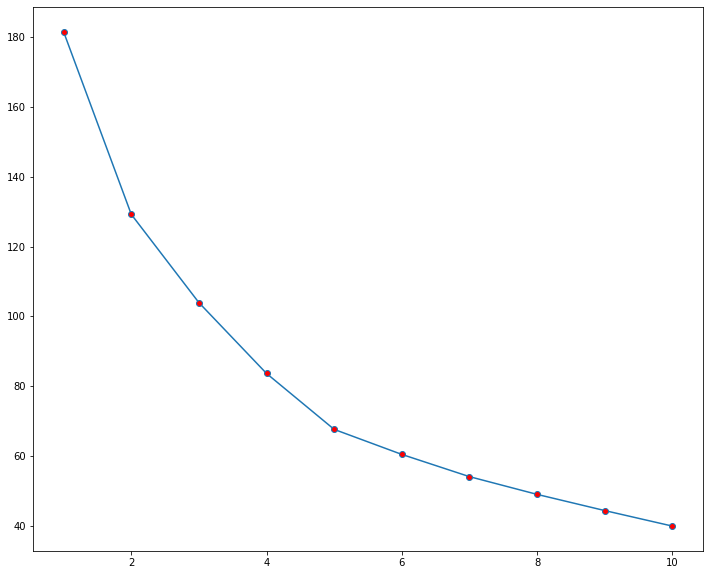

In [339]:
n_cluster = 10
intertias = []
models = []


for n in range(1,n_cluster+1):

  model = KMeans(n_clusters = n, n_init = 10, random_state = 1234)
  model.fit(train_data)
  models.append(model)
  intertias.append(model.inertia_)

fig, ax = plt.subplots(figsize = (12,10))

plt.plot([*range(1,n_cluster+1)], intertias, marker = 'o', markerfacecolor = "red")

In [340]:
model_5_art = KMeans(n_clusters = 5, n_init = 10, random_state = 1234)
model_5_art.fit(train_data)

centres_art = model_5_art.cluster_centers_

results_5_art = pd.DataFrame(centres_art, columns = train_data.columns)


results_5_art

,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_allowed_g_interview,prob_allowed_g_rce,prob_allowed,prob_dismissed,prob_rce,prob_appeal,prob_interview
0,4.420981e-01,2.955884e-03,5.296017e-01,2.534436e-02,0.195028,0.574605,0.003594,0.463226,2.006816e-04,0.265298,1.163494e-02,0.460335
1,-5.551115e-17,-2.168404e-19,1.110223e-16,0.000000e+00,0.018738,0.107522,0.000000,0.055022,-1.355253e-20,0.193195,-1.734723e-18,0.160582
2,3.871021e-01,-2.168404e-19,1.545646e-01,3.787879e-03,0.788907,0.753272,0.000306,0.918528,-2.710505e-20,0.016584,1.208764e-03,0.147818
3,2.154088e-01,7.740989e-04,7.666456e-01,1.717151e-02,0.073165,0.470655,0.002024,0.312711,1.443048e-05,0.322886,1.779184e-02,0.500161
4,5.551115e-17,4.336809e-19,0.000000e+00,-3.469447e-18,0.141475,0.870357,0.001300,0.681939,2.710505e-20,0.121127,3.469447e-18,0.625169


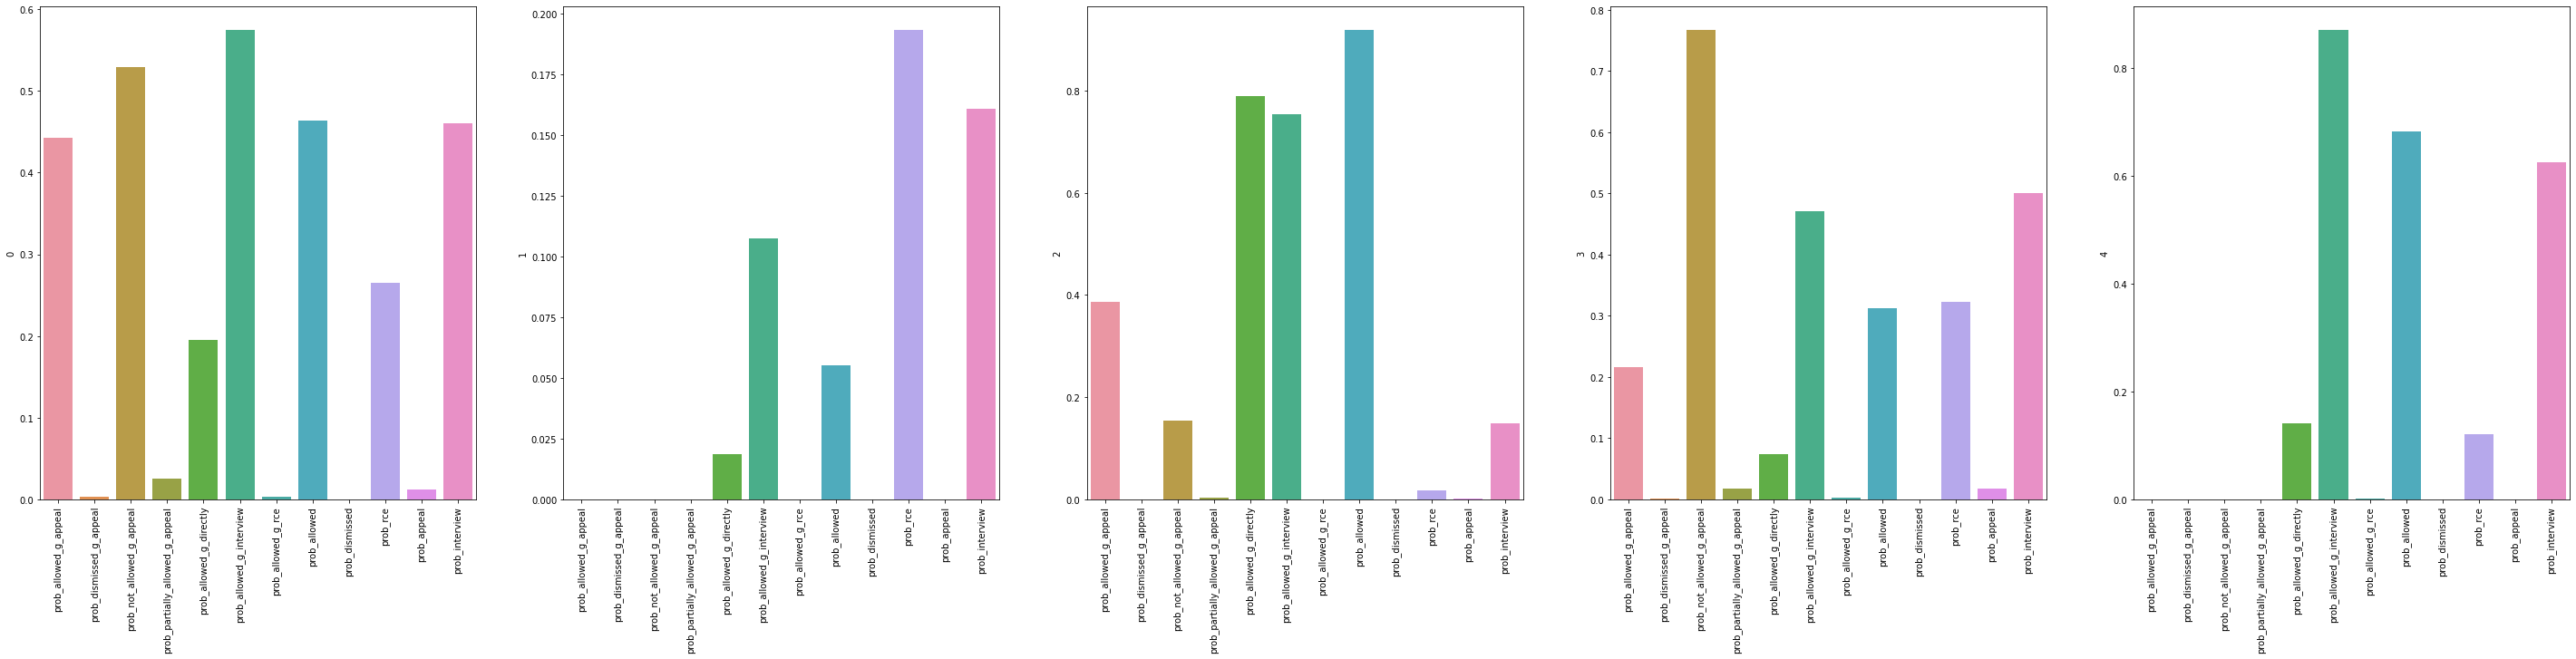

In [341]:
fig, ax = plt.subplots(figsize = (50,10), nrows = 1, ncols = 5, squeeze = True)
for index, col in enumerate(results_5_art.T.columns):
  sns.barplot(x = results_5_art.T.index, y = results_5_art.T[col], ax = ax[index])
  ax[index].set_xticklabels(results_5_art.T.index, rotation = 90)
plt.show()

In [344]:
results_5_art.index =  results_5_art.index + 5

In [345]:
results_5_art.head()

,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_allowed_g_interview,prob_allowed_g_rce,prob_allowed,prob_dismissed,prob_rce,prob_appeal,prob_interview
5,4.420981e-01,2.955884e-03,5.296017e-01,2.534436e-02,0.195028,0.574605,0.003594,0.463226,2.006816e-04,0.265298,1.163494e-02,0.460335
6,-5.551115e-17,-2.168404e-19,1.110223e-16,0.000000e+00,0.018738,0.107522,0.000000,0.055022,-1.355253e-20,0.193195,-1.734723e-18,0.160582
7,3.871021e-01,-2.168404e-19,1.545646e-01,3.787879e-03,0.788907,0.753272,0.000306,0.918528,-2.710505e-20,0.016584,1.208764e-03,0.147818
8,2.154088e-01,7.740989e-04,7.666456e-01,1.717151e-02,0.073165,0.470655,0.002024,0.312711,1.443048e-05,0.322886,1.779184e-02,0.500161
9,5.551115e-17,4.336809e-19,0.000000e+00,-3.469447e-18,0.141475,0.870357,0.001300,0.681939,2.710505e-20,0.121127,3.469447e-18,0.625169


In [359]:
pd.concat([results_5_ex, results_5_art], axis = 0).T.corr()

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.423679,0.434967,0.203589,0.396989,0.794945,0.399611,0.217699,0.979131,0.414697
1,0.423679,1.000000,0.757349,0.264049,0.471073,0.504536,0.967750,0.150073,0.499426,0.678395
2,0.434967,0.757349,1.000000,0.704979,0.536460,0.673418,0.684013,0.618515,0.506931,0.993062
3,0.203589,0.264049,0.704979,1.000000,0.331107,0.500651,0.235740,0.957195,0.223275,0.741900
4,0.396989,0.471073,0.536460,0.331107,1.000000,0.838612,0.443154,0.498421,0.569882,0.522483
5,0.794945,0.504536,0.673418,0.500651,0.838612,1.000000,0.461217,0.601429,0.884763,0.669265
6,0.399611,0.967750,0.684013,0.235740,0.443154,0.461217,1.000000,0.115894,0.467675,0.595249
7,0.217699,0.150073,0.618515,0.957195,0.498421,0.601429,0.115894,1.000000,0.269510,0.665896
8,0.979131,0.499426,0.506931,0.223275,0.569882,0.884763,0.467675,0.269510,1.000000,0.483210
9,0.414697,0.678395,0.993062,0.741900,0.522483,0.669265,0.595249,0.665896,0.483210,1.000000


In [358]:
correlation_between_centres = pd.concat([results_5_ex, results_5_art], axis = 0).T.corr().values[0:5,5:]

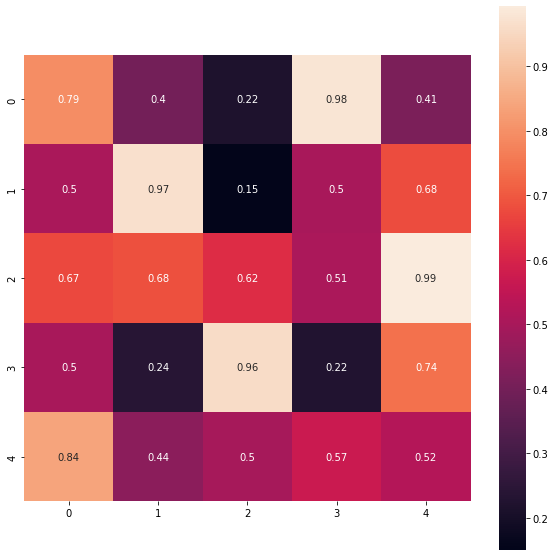

In [356]:
fig, ax = plt.subplots(figsize = (10,10))

corr = data_examiner_model.corr()

# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation_between_centres, annot = True, ax = ax, square = True)

# name = dir + "without_outlier.png"
# plt.savefig(name, dpi = 300, bbox_inches = 'tight')
plt.show()

In [394]:
centre_mapping_ex_to_art = {0:3, 1:1, 2:4, 3:2, 4:0}
centre_mapping_art_to_ex = {value:key for key, value in centre_mapping_ex_to_art.items()}

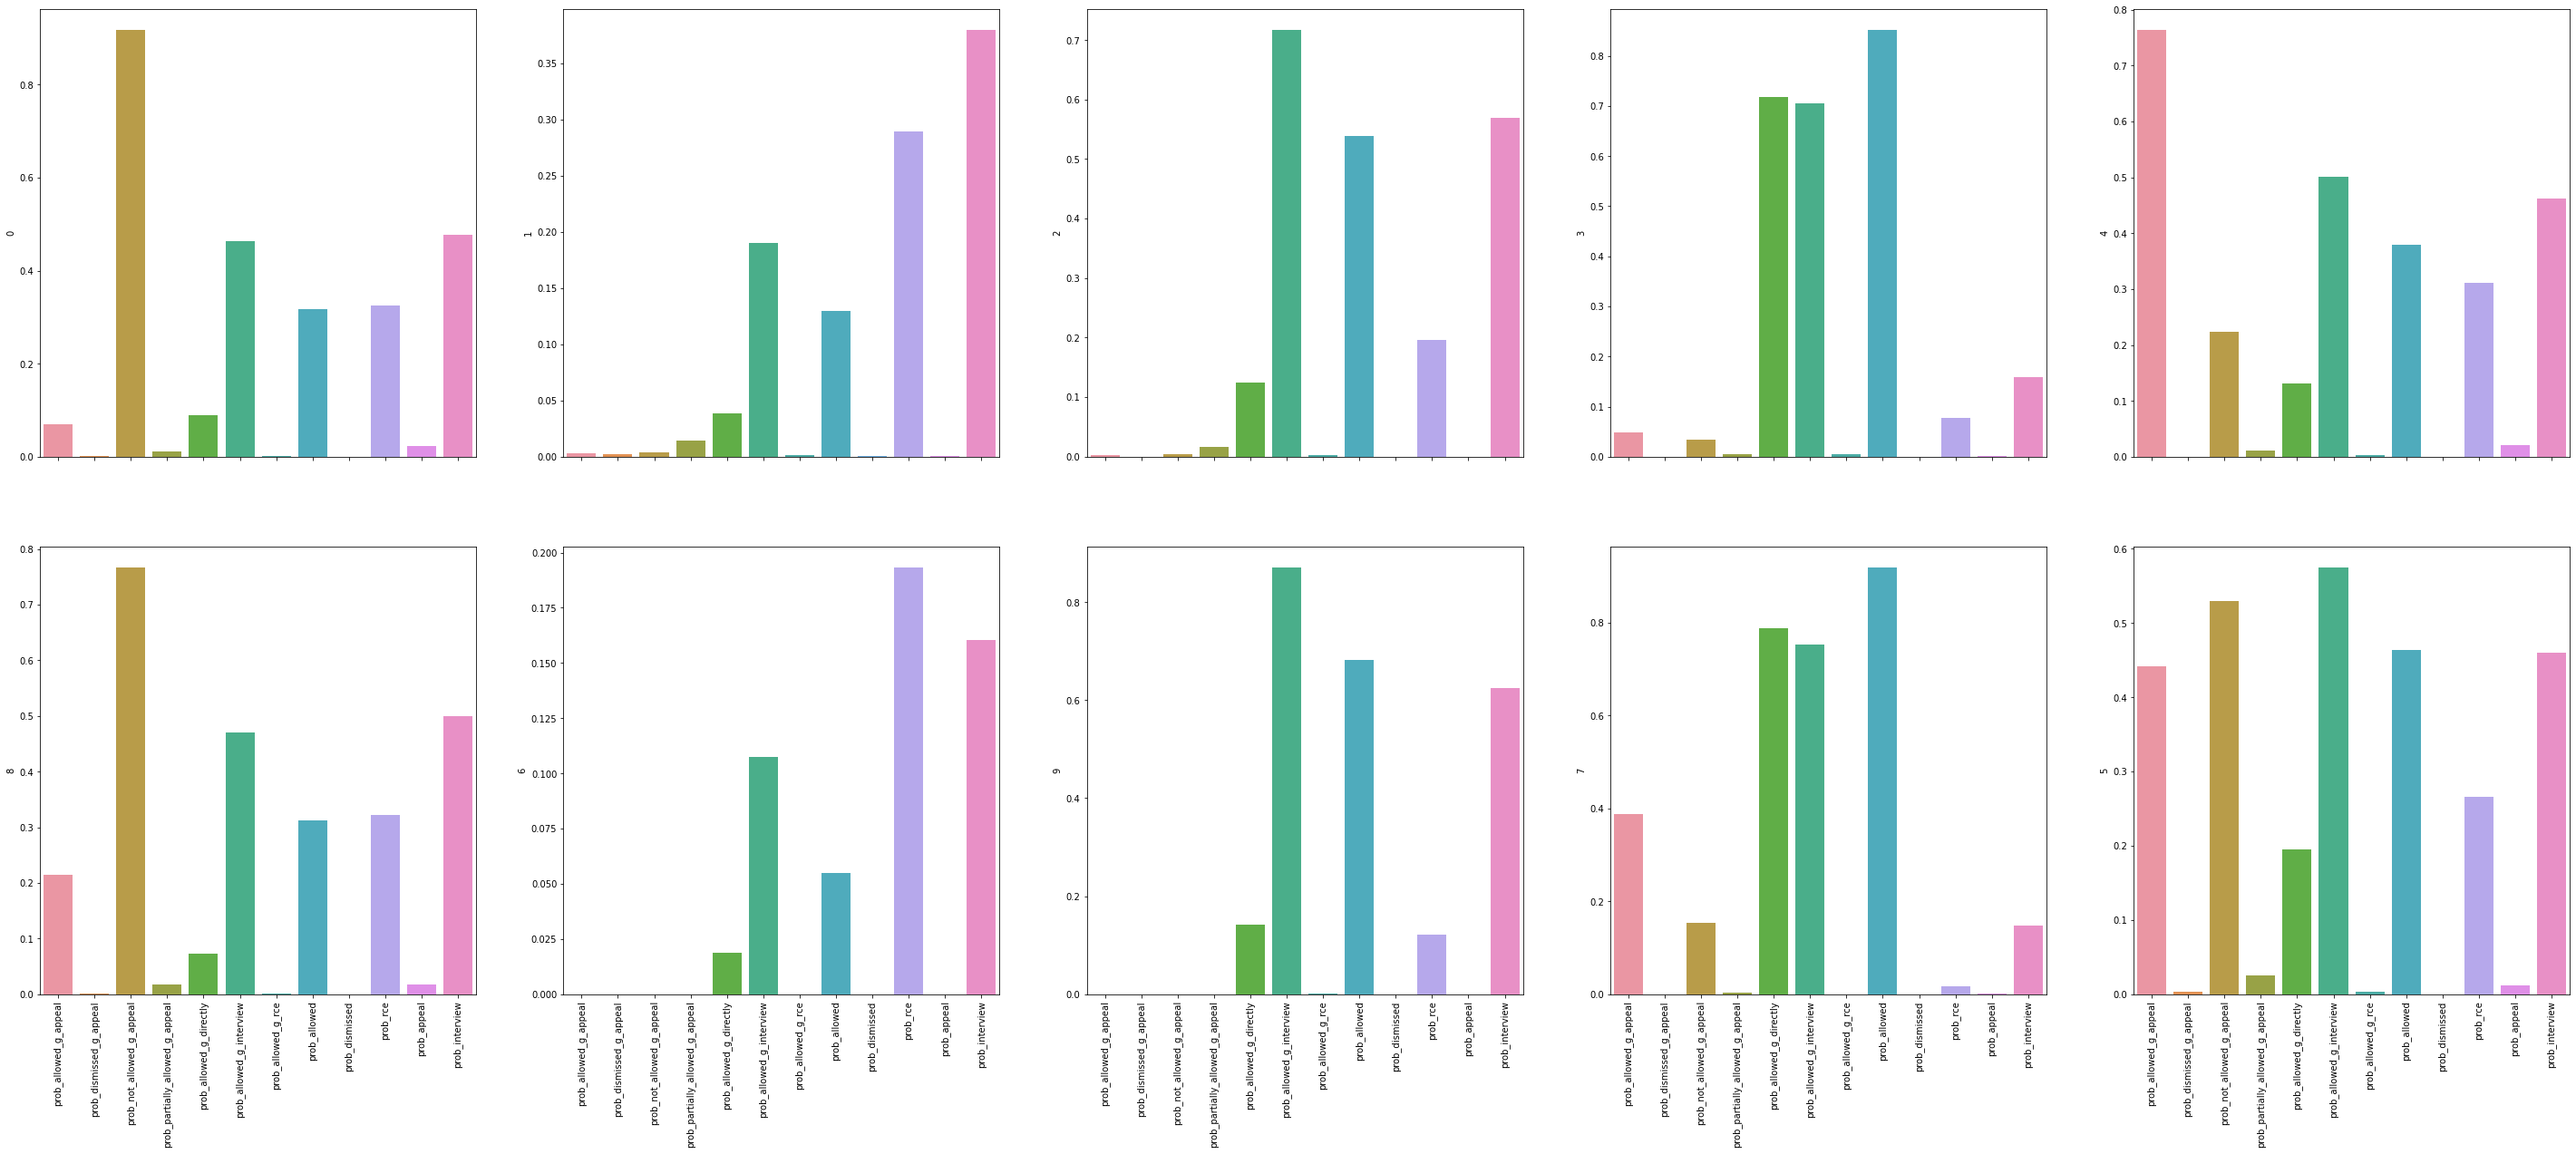

In [366]:
fig, ax = plt.subplots(figsize = (50,20), nrows = 2, ncols = 5, squeeze = True, sharex = True)
for index, col in enumerate(results_5_ex.T.columns):
  sns.barplot(x = results_5_ex.T.index, y = results_5_ex.T[col], ax = ax[0][index])
  sns.barplot(x = results_5_art.T.index, y = results_5_art.T[centre_mapping_ex_to_art[col]+5], ax = ax[1][index])
  ax[1][index].set_xticklabels(results_5_art.T.index, rotation = 90)
plt.show()

,5,6,7,8,9
prob_allowed_g_appeal,0.442098,-5.551115e-17,3.871021e-01,0.215409,5.551115e-17
prob_dismissed_g_appeal,0.002956,-2.168404e-19,-2.168404e-19,0.000774,4.336809e-19
prob_not_allowed_g_appeal,0.529602,1.110223e-16,1.545646e-01,0.766646,0.000000e+00
prob_partially_allowed_g_appeal,0.025344,0.000000e+00,3.787879e-03,0.017172,-3.469447e-18
prob_allowed_g_directly,0.195028,1.873797e-02,7.889066e-01,0.073165,1.414750e-01
prob_allowed_g_interview,0.574605,1.075222e-01,7.532716e-01,0.470655,8.703568e-01
prob_allowed_g_rce,0.003594,0.000000e+00,3.060912e-04,0.002024,1.299702e-03
prob_allowed,0.463226,5.502159e-02,9.185281e-01,0.312711,6.819391e-01
prob_dismissed,0.000201,-1.355253e-20,-2.710505e-20,0.000014,2.710505e-20
prob_rce,0.265298,1.931955e-01,1.658408e-02,0.322886,1.211269e-01


In [386]:
model_5_ex.predict(data_examiner_model[train_columns])

array([4, 0, 2, ..., 2, 4, 0], dtype=int32)

In [387]:
data_examiner_model["predicted_examiner_centre"] = model_5_ex.predict(data_examiner_model[train_columns])

In [389]:
data_examiner_model.head()

,examiner_name,prob_allowed_g_appeal,prob_dismissed_g_appeal,prob_not_allowed_g_appeal,prob_partially_allowed_g_appeal,prob_allowed_g_directly,prob_not_allowed_g_directly,prob_allowed_g_interview,prob_not_allowed_g_interview,prob_allowed_g_rce,prob_not_allowed_g_rce,prob_allowed,prob_dismissed,prob_not_allowed,prob_partially_allowed,prob_appeal,prob_interview,prob_rce,app_group_art_value,predicted_examiner_centre
0,"A, MINH D",0.500000,0.0,0.500000,0.0,0.425926,0.032407,0.479452,0.520548,0.0,1.0,0.592593,0.0,0.407407,0.0,0.009259,0.337963,0.194444,2844,4
1,"A, PHI DIEU TRAN",0.272727,0.0,0.727273,0.0,0.050000,0.081818,0.309735,0.690265,0.0,1.0,0.222727,0.0,0.777273,0.0,0.050000,0.513636,0.304545,3633,0
2,"AAMIR, HAFIZ MUHAMM",0.000000,0.0,0.000000,0.0,0.066667,0.066667,0.809524,0.190476,0.0,1.0,0.633333,0.0,0.366667,0.0,0.000000,0.700000,0.166667,1773,2
3,"ABAD, FARLEY J",0.000000,0.0,0.000000,0.0,0.186275,0.058824,0.584906,0.415094,0.0,1.0,0.490196,0.0,0.509804,0.0,0.000000,0.519608,0.235294,2181,2
4,"ABAZA, AYMAN A",1.000000,0.0,0.000000,0.0,0.013158,0.046053,0.258824,0.741176,0.0,1.0,0.171053,0.0,0.828947,0.0,0.013158,0.559211,0.368421,2419,4


In [392]:
data_art_model["predicted_art_centre"] = model_5_art.predict(data_art_model[train_columns])

In [397]:
data_art_model["predicted_art_centre_examiner_mapped"] = data_art_model["predicted_art_centre"].map(centre_mapping_art_to_ex)

In [396]:
data_art_model["predicted_art_centre"]

0      3
1      3
2      3
3      3
4      3
      ..
629    1
630    0
631    3
632    4
633    4
Name: predicted_art_centre, Length: 634, dtype: int32